In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CrimeAnalysis').getOrCreate()

## Import datasets

In [2]:
# Import modules.
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

#import crime data
df_crime = spark.read.csv('./Datasets/Crimes_-_2012.csv', header = True, inferSchema = True)

#import census data
df_census = spark.read.csv('./Datasets/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv',
                          header = True, inferSchema = True)


## Explorer the data

In [3]:
# print schema for crime dataset
df_crime.printSchema()

# Take the first five rows of crime data, and visualise.
pd.DataFrame(df_crime.take(5), columns = df_crime.columns)

root
 |-- Case Number: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



Case Number        ID     Date         TIME  IUCR        Primary Type  \
0    HZ170962  10433096  1/01/12  12:00:00 AM  1562         SEX OFFENSE   
1    HZ170983  10433124  1/01/12  12:00:00 AM  1544         SEX OFFENSE   
2    JB147078  11227247  1/01/12   9:00:00 AM  1153  DECEPTIVE PRACTICE   
3    JB149037  11228588  4/06/12  12:00:00 PM  1154  DECEPTIVE PRACTICE   
4    JB169720  11244255  1/01/12  12:01:00 AM  1562         SEX OFFENSE   

                               Description Location Description  Arrest  \
0                AGG CRIMINAL SEXUAL ABUSE            RESIDENCE    True   
1           SEXUAL EXPLOITATION OF A CHILD            RESIDENCE    True   
2      FINANCIAL IDENTITY THEFT OVER $ 300            RESIDENCE   False   
3  FINANCIAL IDENTITY THEFT $300 AND UNDER            RESIDENCE   False   
4                AGG CRIMINAL SEXUAL ABUSE            APARTMENT   False   

   Domestic   ...     Ward  FBI Code  X Coordinate Community Area  \
0     False   ...       29        17          None             19   
1     False   ...       29        17          None             19   
2     False   ...       10        11          None             52   
3     False   ...       18        11          None             70   
4     False   ...       31        17          None             19   

  Y Coordinate  Year Latitude     Updated On Longitude Location  
0         None  2012     None  5/11/16 15:48      None     None  
1         None  2012     None  5/11/16 15:48      None     None  
2         None  2012     None  2/11/18 15:57      None     None  
3         None  2012     None  2/12/18 15:49      None     None  
4         None  2012     None  3/02/18 15:54      None     None  

[5 rows x 22 columns]

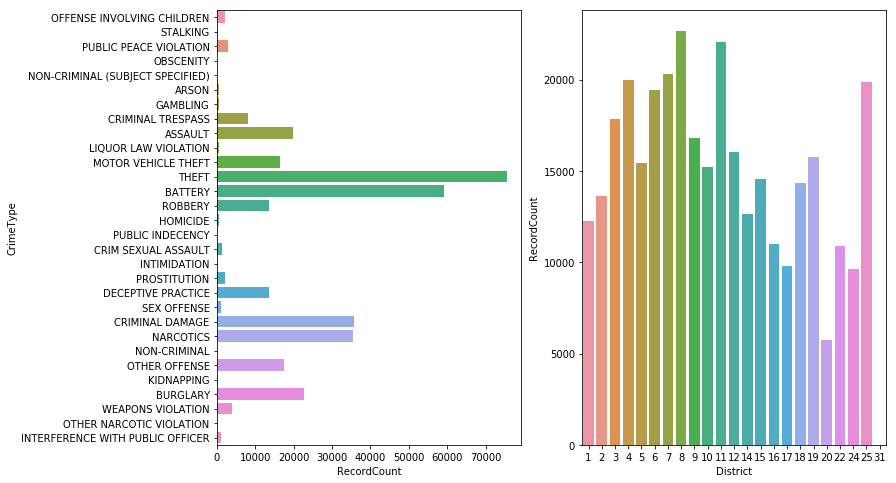

In [4]:
# Column Distribution
# Register DataFrame as SQL View
df_crime.createOrReplaceTempView('tb_crime_clean')

df_crime_type = spark.sql("SELECT `Primary Type` CrimeType, count(*) RecordCount " + 
                           "FROM tb_crime_clean GROUP BY `Primary Type` ")
df_district_type = spark.sql("SELECT District, count(*) RecordCount " + 
                           "FROM tb_crime_clean GROUP BY District ")
df_crime_type = df_crime_type.toPandas()
df_district_type = df_district_type.toPandas()

fig,(ax1,ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12,8)

sn.barplot(x = df_crime_type["RecordCount"],
             y = df_crime_type["CrimeType"],
             data = df_crime_type,
             ax = ax1)
sn.barplot(y = df_district_type["RecordCount"],
             x = df_district_type["District"],
             data = df_district_type,
             ax = ax2)

In [5]:
# print schema for census dataset
df_census.printSchema()

# Take the first five rows of census data, and visualise.
pd.DataFrame(df_census.take(5), columns = df_census.columns)

root
 |-- Community Area Number: integer (nullable = true)
 |-- COMMUNITY AREA NAME: string (nullable = true)
 |-- PERCENT OF HOUSING CROWDED: double (nullable = true)
 |-- PERCENT HOUSEHOLDS BELOW POVERTY: double (nullable = true)
 |-- PERCENT AGED 16+ UNEMPLOYED: double (nullable = true)
 |-- PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA: double (nullable = true)
 |-- PERCENT AGED UNDER 18 OR OVER 64: double (nullable = true)
 |-- PER CAPITA INCOME : integer (nullable = true)
 |-- HARDSHIP INDEX: integer (nullable = true)



Community Area Number COMMUNITY AREA NAME  PERCENT OF HOUSING CROWDED  \
0                      1         Rogers Park                         7.7   
1                      2          West Ridge                         7.8   
2                      3              Uptown                         3.8   
3                      4      Lincoln Square                         3.4   
4                      5        North Center                         0.3   

   PERCENT HOUSEHOLDS BELOW POVERTY  PERCENT AGED 16+ UNEMPLOYED  \
0                              23.6                          8.7   
1                              17.2                          8.8   
2                              24.0                          8.9   
3                              10.9                          8.2   
4                               7.5                          5.2   

   PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                                          18.2   
1                                          20.8   
2                                          11.8   
3                                          13.4   
4                                           4.5   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   HARDSHIP INDEX  
0                              27.5               23939              39  
1                              38.5               23040              46  
2                              22.2               35787              20  
3                              25.5               37524              17  
4                              26.2               57123               6

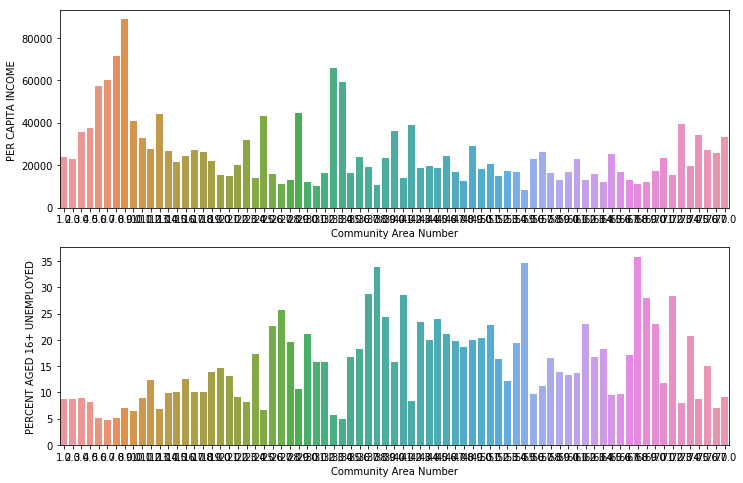

In [6]:
fig,(ax1,ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(12,8)

sn.barplot(x = df_census.toPandas()["Community Area Number"],
             y = df_census.toPandas()["PER CAPITA INCOME "],
             data = df_census.toPandas(),
             ax = ax1)
sn.barplot(x = df_census.toPandas()["Community Area Number"],
             y = df_census.toPandas()["PERCENT AGED 16+ UNEMPLOYED"],
             data = df_census.toPandas(),
             ax = ax2)

## Verify the data quality

In [7]:
# Generating summary statistics for crime data, and converting to a Pandas DataFrame.
df_crime.describe().toPandas()

summary         Case Number                 ID     Date         TIME  \
0   count              335881             335882   335882       335882   
1    mean            342624.8   8685288.95696703     None         None   
2  stddev  115867.13483425746  381750.2318913922     None         None   
3     min              223432              20224  1/01/12  10:00:00 AM   
4     max            VV591657           11399807  9/12/12   9:59:16 PM   

                 IUCR       Primary Type  \
0              335882             335882   
1  1092.0595758438667               None   
2   765.6293334736196               None   
3                031A              ARSON   
4                 937  WEAPONS VIOLATION   

                              Description Location Description  \
0                                  335882               335506   
1                                    None                 None   
2                                    None                 None   
3                          $500 AND UNDER   ABANDONED BUILDING   
4  VIOLATION OF STALKING NO CONTACT ORDER                 YARD   

                 Beat              ...                              Ward  \
0              335882              ...                            335875   
1  1164.1396085530037              ...                22.832925939709714   
2   694.4503023566839              ...                13.784368258262678   
3                 111              ...                                 1   
4                2535              ...                                50   

             FBI Code        X Coordinate      Community Area  \
0              335882              335426              335856   
1  11.711842572676632  1164532.3010231764  37.602945905388026   
2   7.231356670546839     17717.545921822   21.56169954649405   
3                 01A                   0                   0   
4                   9             1205119                  77   

         Y Coordinate    Year             Latitude              Updated On  \
0              335426  335882               335426                  335882   
1  1885423.3761872961  2012.0     41.8411970296055                    None   
2   33479.45196363734     0.0  0.09215121299487906                    None   
3                   0    2012           36.6194464  01/13/2017 03:52:31 PM   
4             1951527    2012          42.02258582           9/11/17 15:50   

             Longitude                       Location  
0               335426                         335426  
1   -87.67175084614298                           None  
2  0.06396285094973082                           None  
3         -91.68656568  (36.619446395, -91.686565684)  
4         -87.52452938  (42.022585817, -87.666121381)  

[5 rows x 21 columns]

In [8]:
# Generating summary statistics for census data, and converting to a Pandas DataFrame.
df_census.describe().toPandas()

summary Community Area Number COMMUNITY AREA NAME  \
0   count                    77                  78   
1    mean                  39.0                None   
2  stddev    22.371857321197094                None   
3     min                     1         Albany Park   
4     max                    77            Woodlawn   

  PERCENT OF HOUSING CROWDED PERCENT HOUSEHOLDS BELOW POVERTY  \
0                         78                               78   
1          4.920512820512823               21.739743589743597   
2            3.6589814413502               11.457230912971083   
3                        0.3                              3.3   
4                       15.8                             56.5   

  PERCENT AGED 16+ UNEMPLOYED PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                          78                                           78   
1          15.341025641025643                            20.33076923076923   
2            7.49949670860991                           11.746514351100048   
3                         4.7                                          2.5   
4                        35.9                                         54.8   

  PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME       HARDSHIP INDEX  
0                               78                  78                  77  
1                35.71794871794873             25597.0  49.506493506493506  
2                7.284421084944951  15196.405541331917   28.69055565156158  
3                             13.5                8201                   1  
4                             51.5               88669                  98

## Clean the data

In [9]:
print("Old crime data frame length:", df_crime.count())      
# Drop only if NaN in “Community Area” for the crime dataset
df_crime = df_crime.dropna(subset=['Community Area'])

# comparing sizes of data frames 
print("New crime data frame length:", df_crime.count())

print("Old census data frame length:", df_census.count())
# Drop only if NaN in “Community Area Number” for the census dataset
df_census = df_census.dropna(subset=['Community Area Number'])

# comparing sizes of data frames 
print("New census data frame length:",  df_census.count())

Old crime data frame length: 335882
New crime data frame length: 335856
Old census data frame length: 78
New census data frame length: 77


## Counstruct the data - Derive new columns

In [10]:
import pyspark.sql.functions as f

# Extract month from "Date"
split_col = f.split(df_crime['Date'], '/')

df_crime = df_crime.withColumn('Day', split_col.getItem(0))

df_crime = df_crime.withColumn('Month', split_col.getItem(1))

# Extract Hour from "TIME"
df_crime = df_crime.withColumn("Hour", 
                            f.from_unixtime(f.unix_timestamp("TIME",'hh:mm:ss aa'),'HH'))

# Verify the results
pd.DataFrame(df_crime.select('Date', 'TIME', 'Day', 'Month', 'Hour').take(15),
             columns = ['Date', 'TIME', 'Day', 'Month', 'Hour'])



Date         TIME Day Month Hour
0    1/01/12  12:00:00 AM   1    01   00
1    1/01/12  12:00:00 AM   1    01   00
2    1/01/12   9:00:00 AM   1    01   09
3    4/06/12  12:00:00 PM   4    06   12
4    1/01/12  12:01:00 AM   1    01   00
5    6/08/12  12:01:00 AM   6    08   00
6    1/01/12  12:01:00 AM   1    01   00
7    1/01/12  12:01:00 AM   1    01   00
8   10/01/12  12:00:00 AM  10    01   00
9   13/04/12  12:00:00 AM  13    04   00
10  12/08/12  12:00:00 PM  12    08   12
11  13/02/12   7:00:00 PM  13    02   19
12   7/05/12   3:00:00 AM   7    05   03
13  15/10/12   3:00:00 PM  15    10   15
14  14/02/12  12:00:00 AM  14    02   00

## Counstruct the data - Aggregation

In [11]:
# Register DataFrame as SQL View
df_crime.createOrReplaceTempView('tb_crime_clean')
df_census.createOrReplaceTempView('tb_census_clean')

# Aggregate crime data by month for analysis 
df_crime_month = spark.sql("SELECT Month, `Primary Type` CrimeType, count(*) RecordCount " + 
                           "FROM tb_crime_clean GROUP BY Month,`Primary Type` ")

# Aggregate crime data by Community Area for analysis 
df_crime_community = spark.sql("SELECT t1.`Community Area` AreaNum, count(*) RecordCount " + 
                               "FROM tb_crime_clean t1, tb_census_clean t2 " + 
                               "WHERE t1.`Community Area` = t2.`Community Area Number` " + 
                               "GROUP BY t1.`Community Area`")

# Aggregate crime data by Hour and merge with the census data for building model 
df_crime_model = spark.sql("SELECT Day, Hour, `Primary Type` CrimeType, " + 
                               "`Community Area` CommunityArea, count(*) RecordCount " + 
                               "FROM tb_crime_clean " + 
                               "GROUP BY Day, Hour, `Primary Type`, `Community Area`")

df_join = df_crime_model.join(df_census, 
                              df_crime_model.CommunityArea == df_census["Community Area Number"],
                              "left_outer")

pd.DataFrame(df_join.take(5), columns = df_join.columns)


Day Hour CrimeType  CommunityArea  RecordCount  Community Area Number  \
0  14   12   BATTERY              3            1                      3   
1   1   16   BATTERY             73            2                     73   
2  11   13  BURGLARY             53            3                     53   
3  18   20     THEFT             32            6                     32   
4  20   13     THEFT              1            2                      1   

  COMMUNITY AREA NAME  PERCENT OF HOUSING CROWDED  \
0              Uptown                         3.8   
1   Washington Height                         1.1   
2        West Pullman                         3.3   
3                Loop                         1.5   
4         Rogers Park                         7.7   

   PERCENT HOUSEHOLDS BELOW POVERTY  PERCENT AGED 16+ UNEMPLOYED  \
0                              24.0                          8.9   
1                              16.9                         20.8   
2                              25.9                         19.4   
3                              14.7                          5.7   
4                              23.6                          8.7   

   PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                                          11.8   
1                                          13.7   
2                                          20.5   
3                                           3.1   
4                                          18.2   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   HARDSHIP INDEX  
0                              22.2               35787              20  
1                              42.6               19713              48  
2                              42.1               16563              62  
3                              13.5               65526               3  
4                              27.5               23939              39

## Data Transformation - Reduce the data

In [12]:
# Select crime type of "THEFT" to build the predition model
df_theft = df_join.where(df_join['CrimeType'] == "THEFT")

# Generating summary statistics for THEFT data
df_theft.describe().toPandas()


summary                 Day                Hour CrimeType  \
0   count               31824               31824     31824   
1    mean  15.820512820512821  12.469582704876823      None   
2  stddev   8.871037563771091  6.5500295012768035      None   
3     min                   1                  00     THEFT   
4     max                   9                  23     THEFT   

        CommunityArea         RecordCount Community Area Number  \
0               31824               31824                 31824   
1   37.50622171945702  2.3709150326797386     37.50622171945702   
2  22.533624205709206  2.1495900003932538    22.533624205709206   
3                   1                   1                     1   
4                  77                  40                    77   

  COMMUNITY AREA NAME PERCENT OF HOUSING CROWDED  \
0               31824                      31824   
1                None          4.976046380090495   
2                None         3.6916016701224343   
3         Albany Park                        0.3   
4            Woodlawn                       15.8   

  PERCENT HOUSEHOLDS BELOW POVERTY PERCENT AGED 16+ UNEMPLOYED  \
0                            31824                       31824   
1               22.300722724987438          15.290491452991457   
2               10.496286205793057           7.519316591929637   
3                              3.3                         4.7   
4                             56.5                        35.9   

  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                                        31824   
1                            19.91188097033686   
2                           11.827952218828393   
3                                          2.5   
4                                         54.8   

  PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME      HARDSHIP INDEX  
0                            31824               31824              31824  
1                34.41386375062848  27109.430492709904  48.62958773252891  
2                7.997774733942049  17503.675042684095  29.38338306266172  
3                             13.5                8201                  1  
4                             51.5               88669                 98

## Data Transformation - Project the data

In [13]:
# Derive a new flag "IsCrimeHigh" as the target of prediction
from pyspark.sql.functions import udf

IsCrimeHigh = udf(lambda RecordCount: "1" if RecordCount >=5 else "0")

df_theft = df_theft.withColumn("IsCrimeHigh", IsCrimeHigh(df_theft.RecordCount))

pd.DataFrame(df_theft.take(5), columns = df_theft.columns)


Day Hour CrimeType  CommunityArea  RecordCount  Community Area Number  \
0  18   20     THEFT             32            6                     32   
1  20   13     THEFT              1            2                      1   
2   6   09     THEFT             66            2                     66   
3  12   00     THEFT             69            5                     69   
4  24   12     THEFT             62            1                     62   

      COMMUNITY AREA NAME  PERCENT OF HOUSING CROWDED  \
0                    Loop                         1.5   
1             Rogers Park                         7.7   
2            Chicago Lawn                         7.6   
3  Greater Grand Crossing                         3.6   
4             West Elsdon                        11.1   

   PERCENT HOUSEHOLDS BELOW POVERTY  PERCENT AGED 16+ UNEMPLOYED  \
0                              14.7                          5.7   
1                              23.6                          8.7   
2                              27.9                         17.1   
3                              29.6                         23.0   
4                              15.6                         16.7   

   PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                                           3.1   
1                                          18.2   
2                                          31.2   
3                                          16.5   
4                                          37.0   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   HARDSHIP INDEX  \
0                              13.5               65526               3   
1                              27.5               23939              39   
2                              40.6               13231              80   
3                              41.0               17285              66   
4                              37.7               15754              69   

  IsCrimeHigh  
0           1  
1           0  
2           0  
3           1  
4           0

In [14]:
# Find out how many data points we have for each class
df_theft.groupby('IsCrimeHigh').count().toPandas()

IsCrimeHigh  count
0           0  28334
1           1   3490

## Data mining - Select the relevant features

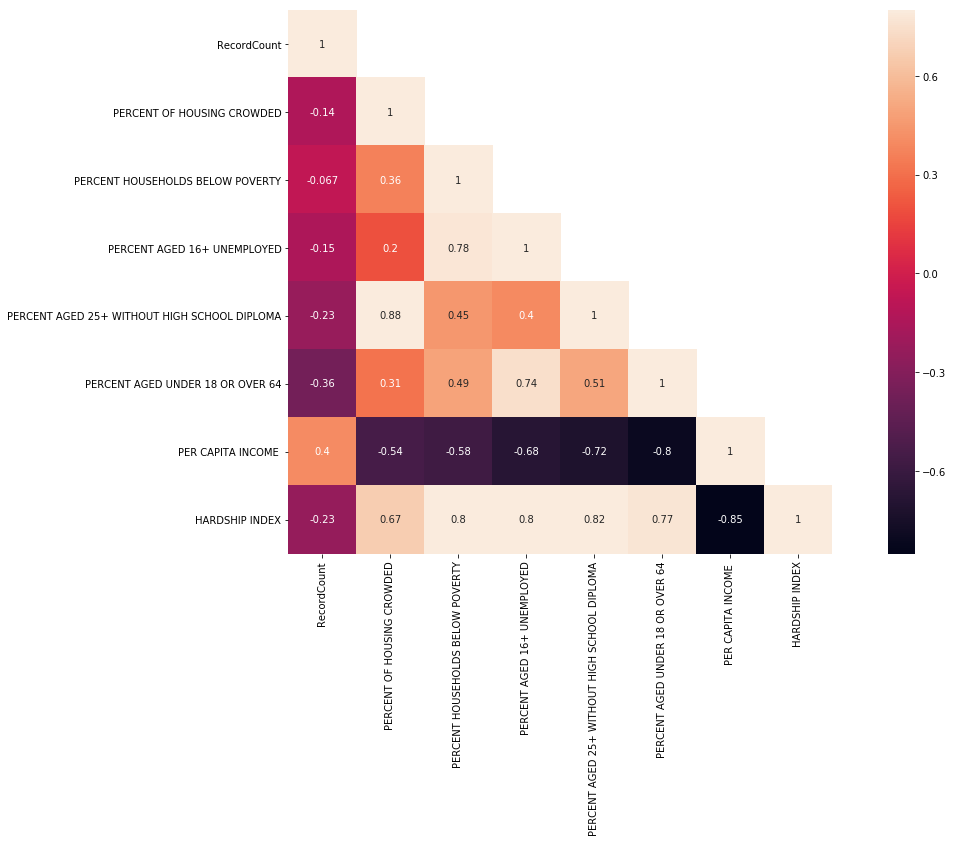

In [15]:
# Feature selection 
corrMatt = df_theft.toPandas()[["RecordCount","PERCENT OF HOUSING CROWDED",
                     "PERCENT HOUSEHOLDS BELOW POVERTY","PERCENT AGED 16+ UNEMPLOYED",
                     "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA",
                     "PERCENT AGED UNDER 18 OR OVER 64",
                     "PER CAPITA INCOME ", "HARDSHIP INDEX"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corrMatt, mask = mask, vmax = 0.8, square = True, annot = True)


In [16]:
df = df_theft.select('Day', 'Hour', 'CommunityArea', 
                     'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ', 'IsCrimeHigh')
df.printSchema()

root
 |-- Day: string (nullable = true)
 |-- Hour: string (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- PERCENT AGED UNDER 18 OR OVER 64: double (nullable = true)
 |-- PER CAPITA INCOME : integer (nullable = true)
 |-- IsCrimeHigh: string (nullable = true)



In [17]:
# Convert String columns to int
from pyspark.sql.types import IntegerType

df = df.withColumn("Day", df["Day"].cast(IntegerType()))
df = df.withColumn("Hour", df["Hour"].cast(IntegerType()))
df = df.withColumn("label", df["IsCrimeHigh"].cast(IntegerType()))
df.printSchema()

root
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- PERCENT AGED UNDER 18 OR OVER 64: double (nullable = true)
 |-- PER CAPITA INCOME : integer (nullable = true)
 |-- IsCrimeHigh: string (nullable = true)
 |-- label: integer (nullable = true)



In [18]:
# Import VectorAssembler and Vectors
from pyspark.ml.feature import VectorAssembler

# Using vector assembler to turn all of these columns into one column (named features).
vector_assembler = VectorAssembler(inputCols=['Day','Hour','CommunityArea','PERCENT AGED UNDER 18 OR OVER 64',
                                       'PER CAPITA INCOME '], outputCol="features")

vector_output = vector_assembler.transform(df)
vector_output = vector_output.select(['features', 'label'])


## Data mining - Split Data

In [19]:
# Split our data. Note that the new DataFrame is being used.
train_data, test_data = vector_output.randomSplit([0.7,0.3], seed = 722)
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 22262
Test Dataset Count: 9562


## Models - Logistic Regression Model


In [20]:
from pyspark.ml.classification import LogisticRegression

# Instantiate the model.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',
                        aggregationDepth = 8)

# Fit the model.
lr_model = lr.fit(train_data)

# And evaluate the model using the test data.
lr_results = lr_model.evaluate(test_data)
lr_results.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,17.0,39.0,35...|    0|[2.00716470472445...|[0.88154727604175...|       0.0|
|[2.0,2.0,10.0,39....|    0|[2.78242792548086...|[0.94171884284491...|       0.0|
|[2.0,14.0,60.0,31...|    0|[2.32959767087176...|[0.91129882054324...|       0.0|
|[3.0,3.0,16.0,31....|    0|[2.50596176599970...|[0.92455870654407...|       0.0|
|[3.0,10.0,24.0,21...|    1|[1.29116780825905...|[0.78434478724989...|       0.0|
|[4.0,6.0,42.0,36....|    0|[2.95428008557956...|[0.95046538782964...|       0.0|
|[4.0,6.0,55.0,42....|    0|[3.23496203744747...|[0.96212896894961...|       0.0|
|[5.0,12.0,21.0,31...|    0|[2.38415879100451...|[0.91561132841508...|       0.0|
|[5.0,18.0,52.0,42...|    0|[2.96083280733219...|[0.95077298702833...|       0.0|
|[6.0,7.0,60.0,3

## Model Evaluation - Logistic Regression Model

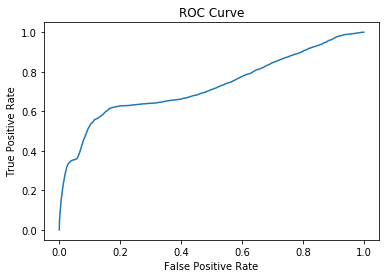

Traning set -LR- Area Under ROC: 0.7261583069771096


In [21]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic for Traning set. 
print('Traning set -LR- Area Under ROC: ' + str(training_summary.areaUnderROC))

In [22]:
# Print the AUC statistic for Testing set. 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Testing set -LR- Area Under ROC', evaluator.evaluate(lr_results.predictions))

Testing set -LR- Area Under ROC 0.7496965478089267


In [27]:
# Define plot_confusion_matrix function for ploting confusion matrix
def plot_confusion_matrix(predictions):
    " This function plots the confusion matrix."   
    cm = predictions.groupby(['label', 'prediction']).count().toPandas()
    true_pos = cm[(cm['label'] == 1) & (cm['prediction'] == 1)]['count'].values[0]
    false_pos = cm[(cm['label'] == 1) & (cm['prediction'] == 0)]['count'].values[0]
    true_neg = cm[(cm['label'] == 0) & (cm['prediction'] == 0)]['count'].values[0]
    false_neg = cm[(cm['label'] == 0) & (cm['prediction'] == 1)]['count'].values[0]
    count_pos = true_pos + false_pos
    count_neg = true_neg + false_neg

    array = [[round(true_neg / count_neg, 4) * 100, round(false_neg / count_neg, 4) * 100],
             [round(false_pos / count_pos, 4) * 100, round(true_pos / count_pos, 4) * 100]]        
    df_cm = pd.DataFrame(array, ["Label Low", "Label High"],
                      ["Predicted Low", "Predicted High"])

    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot = True, fmt='.2f', annot_kws = {"size": 16})

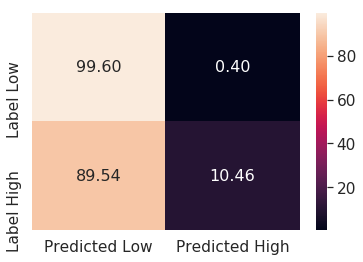

In [24]:
plot_confusion_matrix(lr_results.predictions)

## Tuning parameters - Logistic Regression

In [25]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2, current: 8)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw pr

## Models - Decision Tree Classifier

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',
                            maxBins = 48, maxDepth = 8)
dt_model = dt.fit(train_data)

dt_results = dt_model.transform(test_data)
dt_results.show()

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|[1.0,17.0,39.0,35...|    0|   [97.0,1.0]|[0.98979591836734...|       0.0|
|[2.0,2.0,10.0,39....|    0|[2200.0,11.0]|[0.99502487562189...|       0.0|
|[2.0,14.0,60.0,31...|    0|  [778.0,1.0]|[0.99871630295250...|       0.0|
|[3.0,3.0,16.0,31....|    0|[1071.0,11.0]|[0.98983364140480...|       0.0|
|[3.0,10.0,24.0,21...|    1|[107.0,123.0]|[0.46521739130434...|       1.0|
|[4.0,6.0,42.0,36....|    0|  [296.0,8.0]|[0.97368421052631...|       0.0|
|[4.0,6.0,55.0,42....|    0|[2200.0,11.0]|[0.99502487562189...|       0.0|
|[5.0,12.0,21.0,31...|    0|  [778.0,1.0]|[0.99871630295250...|       0.0|
|[5.0,18.0,52.0,42...|    0|[2724.0,27.0]|[0.99018538713195...|       0.0|
|[6.0,7.0,60.0,31....|    0|  [778.0,1.0]|[0.99871630295250...|       0.0|
|[6.0,9.0,13.0,39....|   

## Model Evaluation - Decision Tree Classifier

In [27]:
print("Testing set -DT- Area Under ROC: " + str(evaluator.evaluate(dt_results, {evaluator.metricName: "areaUnderROC"})))

Testing set -DT- Area Under ROC: 0.7778487222117092


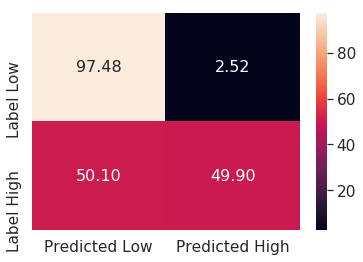

In [28]:
plot_confusion_matrix(dt_results)

## Tuning parameters - Decision Tree

In [29]:
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32, current: 48)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 

## Models - Random Forest Classifier

In [35]:
from pyspark.ml.classification import RandomForestClassifier


rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',
                            maxBins = 48, maxDepth = 8,
                            numTrees = 10)
rf_model = rf.fit(train_data)

rf_results = rf_model.transform(test_data)
rf_results.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,17.0,39.0,35...|    0|[9.9079017802907,...|[0.99079017802907...|       0.0|
|[2.0,2.0,10.0,39....|    0|[9.99698976520168...|[0.99969897652016...|       0.0|
|[2.0,14.0,60.0,31...|    0|[9.96224989429399...|[0.99622498942939...|       0.0|
|[3.0,3.0,16.0,31....|    0|[9.87365138356107...|[0.98736513835610...|       0.0|
|[3.0,10.0,24.0,21...|    1|[4.95398071204880...|[0.49539807120488...|       1.0|
|[4.0,6.0,42.0,36....|    0|[9.85578403993109...|[0.98557840399310...|       0.0|
|[4.0,6.0,55.0,42....|    0|[9.98605453060754...|[0.99860545306075...|       0.0|
|[5.0,12.0,21.0,31...|    0|[9.97091233209351...|[0.99709123320935...|       0.0|
|[5.0,18.0,52.0,42...|    0|[9.83185861338893...|[0.98318586133889...|       0.0|
|[6.0,7.0,60.0,3

## Model Evaluation - Random Forest Classifier

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Testing set -RF- Area Under ROC: " + str(evaluator.evaluate(rf_results, {evaluator.metricName: "areaUnderROC"})))

Testing set -RF- Area Under ROC: 0.9186189996665853


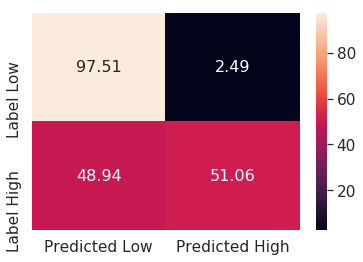

In [37]:
plot_confusion_matrix(rf_results)

## Tuning parameters - Random Forest

In [33]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must 

## Interpretation

[Text(0,0.5,'Crime Count'),
 Text(0.5,0,'Month Of The Year'),
 Text(0.5,1,'Crime Trend By Month Of The Year'),
 None]

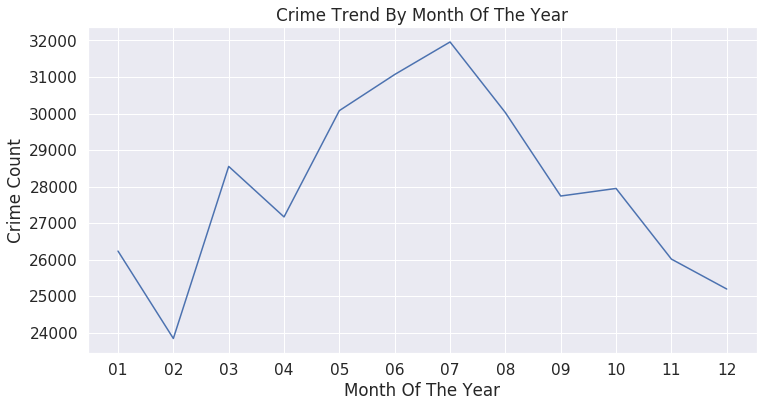

In [34]:
# Criminal Activities Trend
fig,ax = plt.subplots(nrows = 1)
fig.set_size_inches(12,6)
monthAggregated = pd.DataFrame(df_crime_month.toPandas().groupby(["Month"])["RecordCount"].sum()).reset_index()

sn.lineplot(x = monthAggregated["Month"],
             y = monthAggregated["RecordCount"],
             data = monthAggregated,
             ax = ax)
ax.set(xlabel = 'Month Of The Year', ylabel='Crime Count',
        title = "Crime Trend By Month Of The Year",
        label = 'big')



[Text(0,0.5,'Crime Type'),
 Text(0.5,0,'Crime Count'),
 Text(0.5,1,'Crime Rate Across of Crime Type'),
 None]

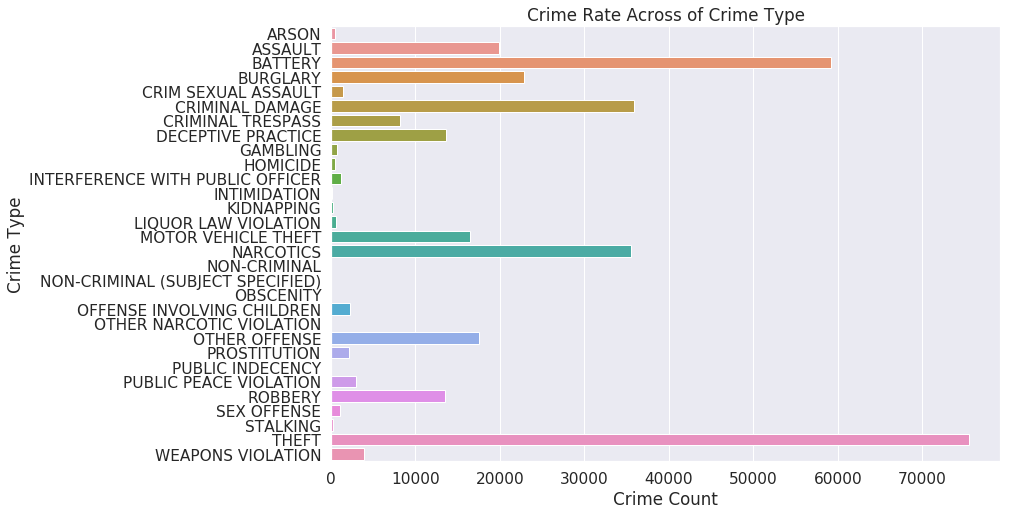

In [35]:
# Crime Type Distribution
fig,ax = plt.subplots(nrows = 1)
fig.set_size_inches(12,8)
typeAggregated = pd.DataFrame(df_crime_month.toPandas().groupby(["CrimeType"])["RecordCount"].sum()).reset_index()

sn.barplot(x = typeAggregated["RecordCount"],
             y = typeAggregated["CrimeType"],
             data = typeAggregated,
             ax = ax)
ax.set(xlabel = 'Crime Count', ylabel='Crime Type',
        title = "Crime Rate Across of Crime Type",
        label = 'big')

[Text(0,0.5,'Crime Count'),
 Text(0.5,0,'Month Of The Year'),
 Text(0.5,1,'THEFT By Month'),
 None]

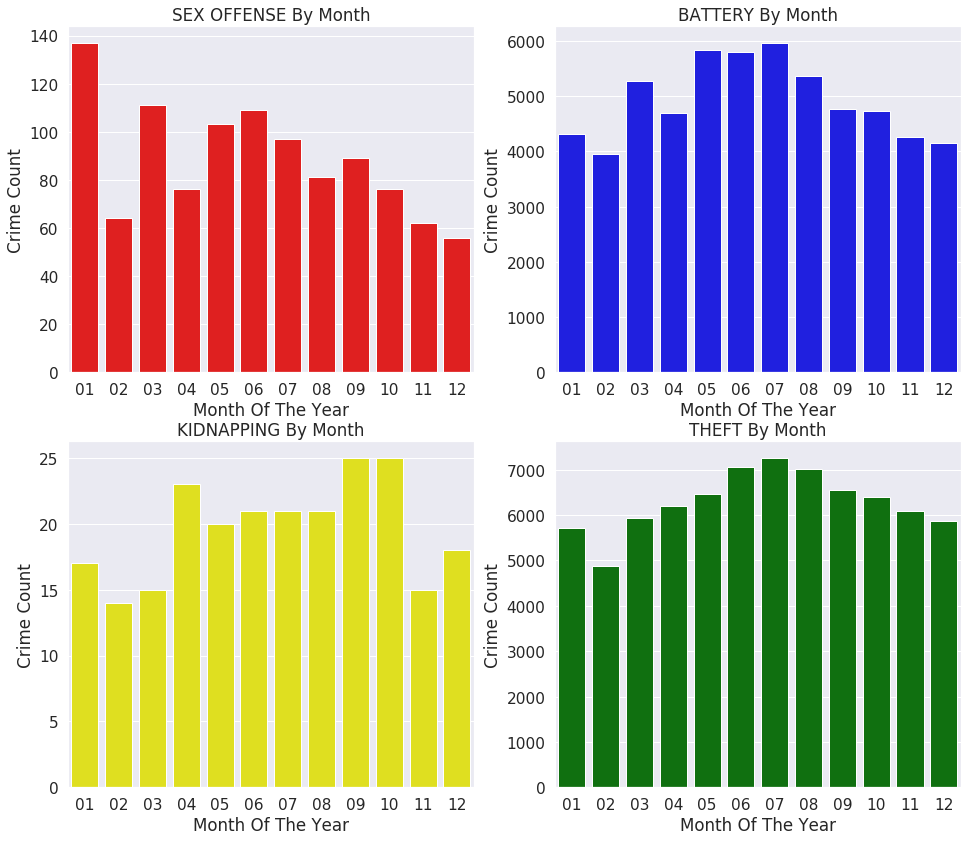

In [36]:
# Different Crime Type By Month
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(16, 14)
# Plot SEX OFFENSE
sexAggregated = pd.DataFrame(df_crime_month.where(df_crime_month['CrimeType'] == "SEX OFFENSE").
                             toPandas().groupby(["Month"])["RecordCount"].sum()).reset_index()
sn.barplot(x = sexAggregated["Month"],
             y = sexAggregated["RecordCount"],
             data = sexAggregated,
             color = "red",
             ax = axes[0][0])
# Plot BATTERY
batteryAggregated = pd.DataFrame(df_crime_month.where(df_crime_month['CrimeType'] == "BATTERY").
                             toPandas().groupby(["Month"])["RecordCount"].sum()).reset_index()
sn.barplot(x = batteryAggregated["Month"],
             y = batteryAggregated["RecordCount"],
             data = batteryAggregated,
             color = "blue",
             ax = axes[0][1])
# Plot KIDNAPPING
kidnapAggregated = pd.DataFrame(df_crime_month.where(df_crime_month['CrimeType'] == "KIDNAPPING").
                             toPandas().groupby(["Month"])["RecordCount"].sum()).reset_index()
sn.barplot(x = kidnapAggregated["Month"],
             y = kidnapAggregated["RecordCount"],
             data = kidnapAggregated,
             color = "yellow",
             ax = axes[1][0])
# Plot THEFT
theftAggregated = pd.DataFrame(df_crime_month.where(df_crime_month['CrimeType'] == "THEFT").
                             toPandas().groupby(["Month"])["RecordCount"].sum()).reset_index()
sn.barplot(x = theftAggregated["Month"],
             y = theftAggregated["RecordCount"],
             data = theftAggregated,
             color = "green",
             ax = axes[1][1])

axes[0][0].set(xlabel = 'Month Of The Year', ylabel='Crime Count',
        title = "SEX OFFENSE By Month",
        label = 'small')
axes[0][1].set(xlabel = 'Month Of The Year', ylabel='Crime Count',
        title = "BATTERY By Month",
        label = 'small')
axes[1][0].set(xlabel = 'Month Of The Year', ylabel='Crime Count',
        title = "KIDNAPPING By Month",
        label = 'small')
axes[1][1].set(xlabel = 'Month Of The Year', ylabel='Crime Count',
        title = "THEFT By Month",
        label = 'small')

[Text(0.5,1,'Top 10 Communities have highest THEFT rate')]

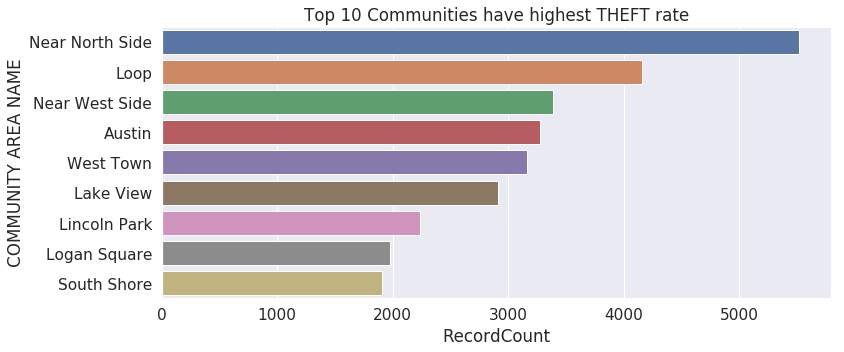

In [37]:
# Top 10 Communities have highest THEFT rate
theft_community = df_theft.toPandas().groupby(["COMMUNITY AREA NAME"])["RecordCount"].sum().reset_index()
theft_community = theft_community.sort_values(by='RecordCount', ascending=False)

fig,ax1 = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)
sn.barplot(x = "RecordCount", y = "COMMUNITY AREA NAME", data = theft_community[0:9], ax = ax1)
ax1.set(title = "Top 10 Communities have highest THEFT rate")


[Text(0,0.5,'THEFT Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'THEFT Activities By Hour Of The Day Across Communities'),
 None]

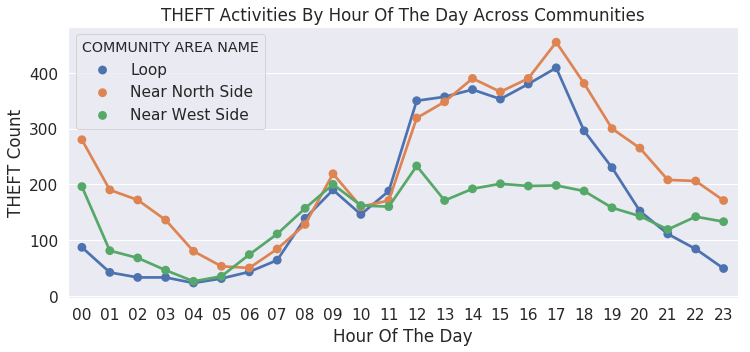

In [38]:
# THEFT Activities By Hour Of The Day Across Top 3 Communities
theft_community_top3 = df_theft.where((df_theft['COMMUNITY AREA NAME'] == "Near North Side") | 
                                     (df_theft['COMMUNITY AREA NAME'] == "Loop") |
                                     (df_theft['COMMUNITY AREA NAME'] == "Near West Side"))
theft_community_top3 = theft_community_top3.toPandas().groupby(["Hour", "COMMUNITY AREA NAME"])["RecordCount"].sum().reset_index()

fig,ax1 = plt.subplots()
fig.set_size_inches(12, 5)
sn.pointplot(x = theft_community_top3["Hour"],
             y = theft_community_top3["RecordCount"],
             hue = theft_community_top3["COMMUNITY AREA NAME"],
             data = theft_community_top3, join = True, ax = ax1)
ax1.set(xlabel = 'Hour Of The Day', ylabel = 'THEFT Count',
        title = "THEFT Activities By Hour Of The Day Across Communities", label = 'big')

[Text(0.5,1,'THEFT Crime Rate In Chicago')]

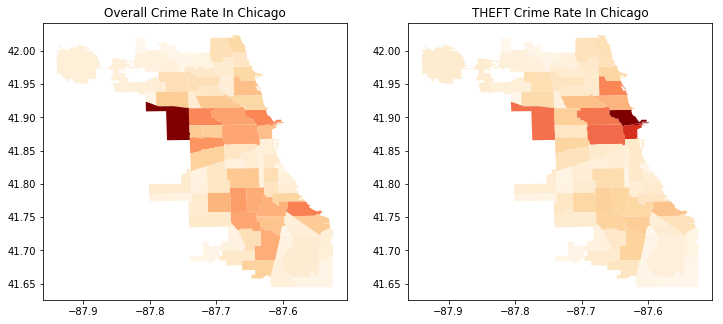

In [21]:
# Crime rate in Chicago
import geopandas as gpd
df_chicago = gpd.read_file('./Datasets/BoundariesCommunityArea.geojson')
df_chicago['area_numbe'] = df_chicago['area_numbe'].astype(int)

# Overall 
df_chicago_all = df_chicago.join(df_crime_community.toPandas().set_index('AreaNum'),
                                 on='area_numbe')
# THEFT
theft_area_num = df_theft.toPandas().groupby(["CommunityArea"])["RecordCount"].sum().reset_index()
df_chicago_theft = df_chicago.join(theft_area_num.set_index('CommunityArea'), on='area_numbe')

fig,(ax1,ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12, 6)
df_chicago_all.plot(ax = ax1, column='RecordCount', cmap='OrRd')
ax1.set(title = "Overall Crime Rate In Chicago")

df_chicago_theft.plot(ax = ax2, column='RecordCount', cmap='OrRd')
ax2.set(title = "THEFT Crime Rate In Chicago")


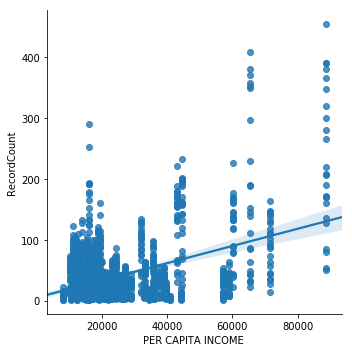

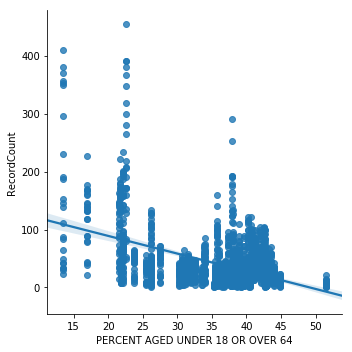

In [22]:
# Correlation Analysis
corr = df_theft.toPandas().groupby(["Hour", "PER CAPITA INCOME ", "PERCENT AGED UNDER 18 OR OVER 64"])["RecordCount"].sum().reset_index()
sn.lmplot(x = "PER CAPITA INCOME ", y = "RecordCount",
           data = corr)
sn.lmplot(x = "PERCENT AGED UNDER 18 OR OVER 64", y = "RecordCount",
           data = corr)


[Text(0.5,1,'High risk of THEFT(Predicted) In Chicago')]

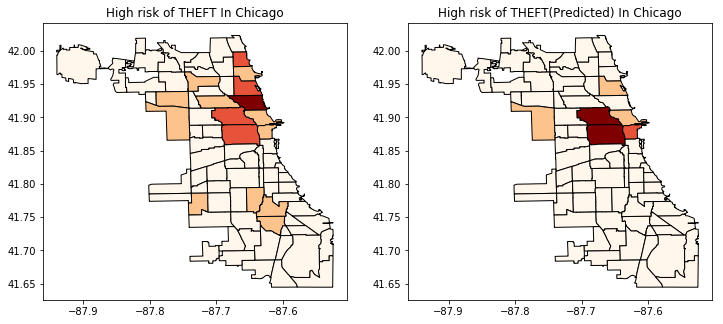

In [24]:
# Prediction Comparison
from pyspark.ml.feature import VectorSlicer
from pyspark.ml import Pipeline

# Get the day,Hour,Community information from features
day_slicer = VectorSlicer(inputCol = "features", outputCol = "day", indices = [0])
hour_slicer = VectorSlicer(inputCol = "features", outputCol = "hour", indices = [1])
community_slicer = VectorSlicer(inputCol = "features", outputCol = "community", indices = [2])

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[day_slicer, hour_slicer, community_slicer])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(rf_results)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(rf_results)

# Function for changing vector to integer
vec2int = f.udf(lambda x : int(x[0]),IntegerType())

# select variables
pipe_df = pipe_df.select('label', 'prediction',
                         vec2int('day').alias('day'),
                         vec2int('hour').alias('hour'),
                         vec2int('community').alias('community'))

# Select subset day = 15, hour between 12 and 17
pred_comp = pipe_df.where((pipe_df['day'] == 15) & 
                          (pipe_df['hour'] >= 12) & 
                          (pipe_df['hour'] <= 17))
pred_comp = pred_comp.toPandas().groupby(["community"])["label", "prediction"].sum().reset_index()

df_chicago_comp = df_chicago.join(pred_comp.set_index('community'), on='area_numbe')
df_chicago_comp = df_chicago_comp.fillna(0)

fig,(ax1,ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12, 6)
df_chicago_comp.plot(ax = ax1, column='label', edgecolor='black', cmap='OrRd')
ax1.set(title = "High risk of THEFT In Chicago")

df_chicago_comp.plot(ax = ax2, column='prediction', edgecolor='black', cmap='OrRd')
ax2.set(title = "High risk of THEFT(Predicted) In Chicago")
